Table of Contents

- [Import data](#1)
- [Overview](#2)
- [Visualization](#3)

In [258]:
import pandas as pd
#pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor

In [259]:
##functions below are originally from https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic

def percent_value_counts(df, feature):
    """This function takes in a dataframe and a column and finds the percentage of the value_counts"""
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    total.columns = ["Total"]
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)

def cabin_estimator(i):
    """Grouping cabin feature by the first letter"""
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

## create bins for age
def age_group_fun(age):
    """
    This function creates a bin for age
    """
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'youngAdult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middleAged'
    elif age <= 65:
        a = 'senior'
    else:
        a = 'elderly'
    return a

## Import data

In [424]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

##concat both train and test data for data cleaning
trainrow = df_train.shape[0]
testrow = df_test.shape[0]
testids = df_test['PassengerId'].copy()
trainids = df_train['PassengerId'].copy()
y_train = df_train['Survived'].copy()

##X: complete set with no target variable
X = pd.concat((df_train, df_test)).reset_index(drop=True)
X = X.drop('Survived', axis = 1)
#X = X.drop('PassengerId', axis = 1)

##X_train: complete train set
X_train = X.iloc[:trainrow]
X_train['Survived'] = pd.Series(y_train)

## 1. Overview <a id="2"></a>

In [261]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')

### Train set

In [262]:
X_train.describe(include =['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Lahoud, Mr. Sarkis",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


In [263]:
survived_summary = X_train.groupby("Survived")
survived_summary.mean().reset_index()

,Survived,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


In [264]:
survived_summary = X_train.groupby("Sex")
survived_summary.mean().reset_index()

,Sex,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
0,female,431.028662,2.159236,27.915709,0.694268,0.649682,44.479818,0.742038
1,male,454.147314,2.389948,30.726645,0.429809,0.235702,25.523893,0.188908


In [265]:
survived_summary = X_train.groupby("Pclass")
survived_summary.mean().reset_index()

,Pclass,PassengerId,Age,SibSp,Parch,Fare,Survived
0,1,461.597222,38.233441,0.416667,0.356481,84.154687,0.629630
1,2,445.956522,29.877630,0.402174,0.380435,20.662183,0.472826
2,3,439.154786,25.140620,0.615071,0.393075,13.675550,0.242363


### Test set

In [266]:
df_test.describe(include =['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Bowen, Miss. Grace Scott",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [267]:
survived_summary = df_test.groupby("Sex")
survived_summary.mean().reset_index()

,Sex,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,female,1096.789474,2.144737,30.272362,0.565789,0.598684,49.747699
1,male,1102.620301,2.334586,30.272732,0.379699,0.274436,27.527877


In [268]:
survived_summary = df_test.groupby("Pclass")
survived_summary.mean().reset_index()

,Pclass,PassengerId,Age,SibSp,Parch,Fare
0,1,1098.224299,40.918367,0.476636,0.383178,94.280297
1,2,1117.935484,28.777500,0.376344,0.344086,22.202104
2,3,1094.178899,24.027945,0.463303,0.417431,12.459678


## Visualization <a id="3"></a>

### Pclass

In [269]:
temp = X_train[['Pclass', 'Survived', 'PassengerId']].groupby(['Pclass', 'Survived']).count().reset_index()
temp_df = pd.pivot_table(temp, values = 'PassengerId', index = 'Pclass',columns = 'Survived')
names = ['No', 'Yes']
temp_df.columns = names
r = [0,1,2]
totals = [i+j for i, j in zip(temp_df['No'], temp_df['Yes'])]
No_s = [i / j * 100 for i,j in zip(temp_df['No'], totals)]
Yes_s = [i / j * 100 for i,j in zip(temp_df['Yes'], totals)]

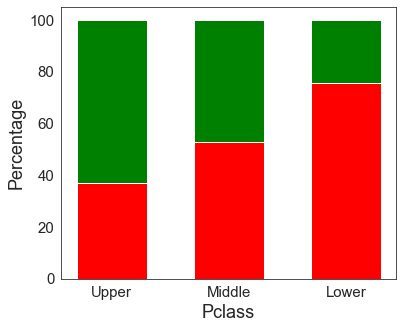

In [274]:
## Stacked plot
plt.subplots(figsize = (6,5))
barWidth = 0.60
names = ('Upper', 'Middle', 'Lower')

plt.bar(r, No_s, color='Red', edgecolor='white', width=barWidth)
plt.bar(r, Yes_s, bottom=No_s, color='Green', edgecolor='white', width=barWidth)

plt.xticks(r, names, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Pclass", fontsize = 18)
plt.ylabel('Percentage', fontsize = 18)
plt.show()

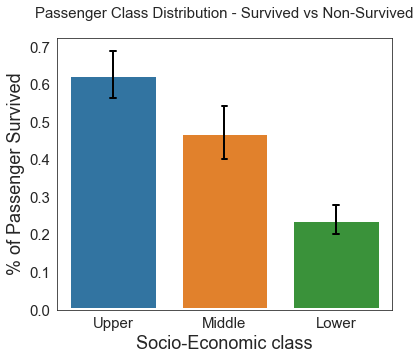

In [282]:
### non-stacked plot
plt.subplots(figsize = (6,5))
sns.barplot(x = "Pclass", 
            y = "Survived", 
            data=X_train, 
            linewidth=5,
            capsize = .05,
            errcolor='black',
            errwidth = 2)
plt.title("Passenger Class Distribution - Survived vs Non-Survived", fontsize = 15, pad=20)
plt.xlabel("Socio-Economic class", fontsize = 18);
plt.ylabel("% of Passenger Survived", fontsize = 18);
names = ['Upper', 'Middle', 'Lower']
val = [0,1,2] ## this is just a temporary trick to get the label right. 
plt.xticks(val, names, fontsize = 15)
plt.yticks(fontsize = 15);

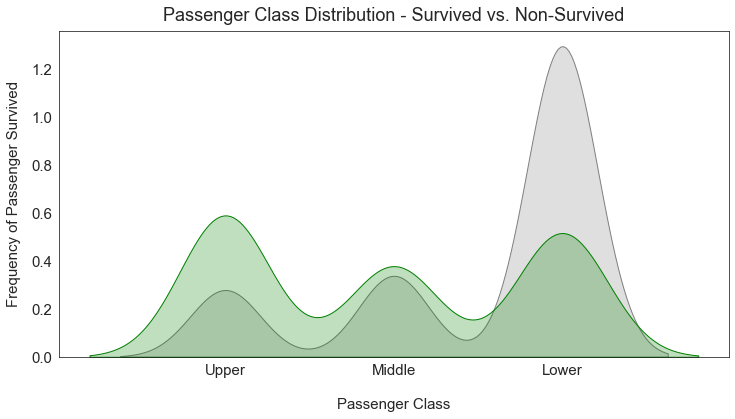

In [286]:
##KDE plot: Kernel Density Estimation Plot
fig = plt.figure(figsize=(12,6),)
ax=sns.kdeplot(X_train.Pclass[X_train.Survived == 0] , 
               color='gray',
               shade=True,
               label='not survived')
ax=sns.kdeplot(X_train.loc[(X_train['Survived'] == 1),'Pclass'] , 
               color='green',
               shade=True, 
               label='survived')
plt.title('Passenger Class Distribution - Survived vs. Non-Survived', fontsize = 18, pad = 10)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15, labelpad = 10)
plt.xlabel("Passenger Class", fontsize = 15,labelpad =20)
labels = ['Upper', 'Middle', 'Lower']
plt.yticks(fontsize = 15)
plt.xticks(sorted(X_train.Pclass.unique()), labels, fontsize = 15);

### Sex

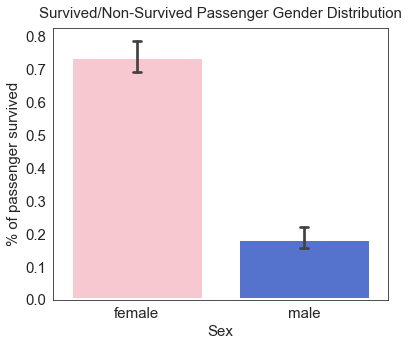

In [287]:
pal = {'male':"royalblue", 'female':"Pink"}
plt.subplots(figsize = (6,5))
ax = sns.barplot(x = "Sex", 
                 y = "Survived", 
                 data = X_train, 
                 palette = pal,
                 linewidth=5,
                 order = ['female','male'],
                 capsize = .05)
plt.title("Survived/Non-Survived Passenger Gender Distribution", fontsize = 15,loc = 'center', pad = 10)
plt.ylabel("% of passenger survived", fontsize = 15, )
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Sex",fontsize = 15);

### Age: continuous numerical variable

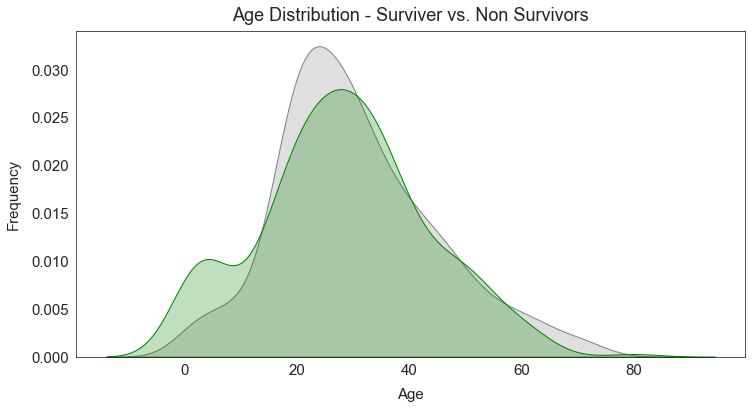

In [290]:
# Kernel Density Plot
fig = plt.figure(figsize = (12,6),)
ax=sns.kdeplot(X_train.loc[(X_train['Survived'] == 0),'Age'] , color = 'gray', shade = True,label = 'not survived')
ax=sns.kdeplot(X_train.loc[(X_train['Survived'] == 1),'Age'] , color = 'green', shade = True, label = 'survived')
plt.title('Age Distribution - Surviver vs. Non Survivors', fontsize = 18, pad = 10)
plt.xlabel("Age", fontsize = 15, labelpad = 10)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Frequency', fontsize = 15, labelpad = 10);

### Fare: continuous numerical variable

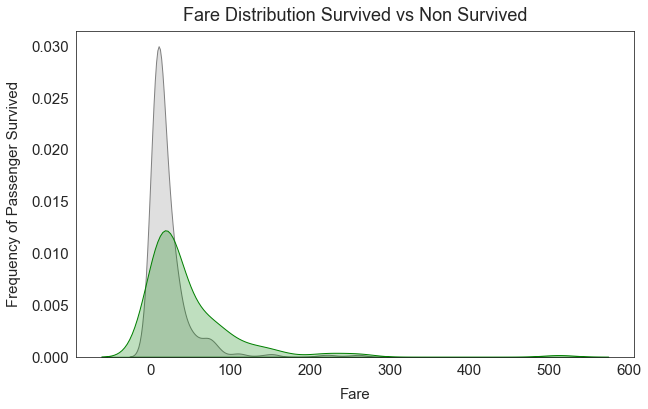

In [292]:
fig = plt.figure(figsize = (10,6))
ax=sns.kdeplot(X_train.loc[(X_train['Survived'] == 0),'Fare'] , color = 'gray', shade= True,label = 'not survived')
ax=sns.kdeplot(X_train.loc[(X_train['Survived'] == 1),'Fare'] , color = 'green', shade= True, label = 'survived')
plt.title('Fare Distribution Survived vs Non Survived', fontsize = 18, pad = 10)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15, labelpad = 10)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Fare", fontsize = 15, labelpad = 10);

In [371]:
X_train[X_train.Fare > 300]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,1
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,1
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,1


In [301]:
X[X.Fare > 300]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
1234,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


In [295]:
pal = {1:"seagreen", 0:"gray"}

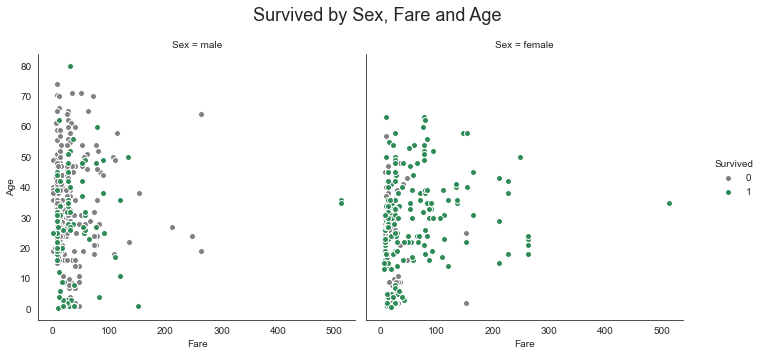

In [298]:
g = sns.FacetGrid(X_train, size= 5, hue = "Survived", col = "Sex", margin_titles = True, palette=pal)
g.map(plt.scatter, "Fare", "Age", edgecolor="white").add_legend()
g.fig.suptitle("Survived by Sex, Fare and Age", size = 18)
plt.subplots_adjust(top=0.85)

I can remove these three outliers, replace them with mean values of first class ticket fare, or I can use **RobustScaler** that is not sensitive to outliers

In [425]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


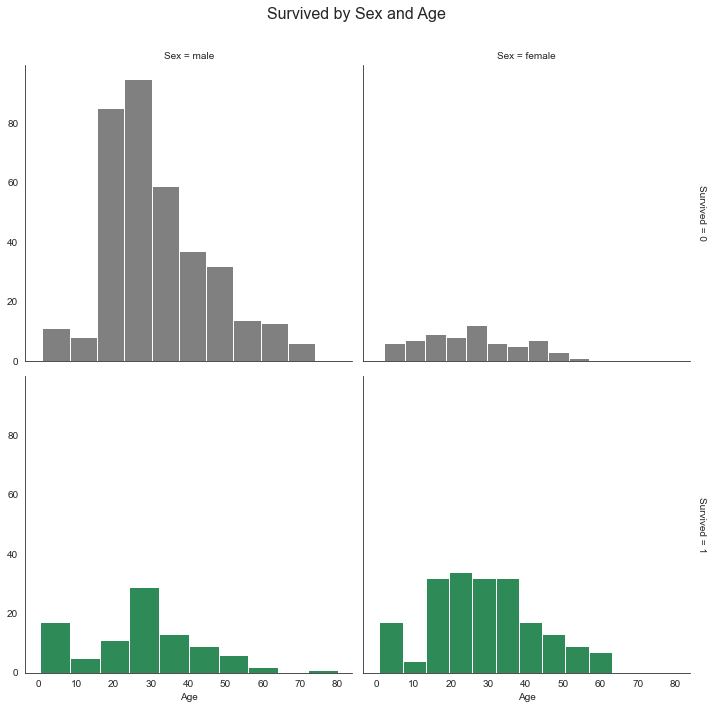

In [299]:
g = sns.FacetGrid(X_train, size=5, col="Sex", row="Survived", margin_titles=True, hue = "Survived", palette=pal)
g = g.map(plt.hist, "Age", edgecolor = 'white');
g.fig.suptitle("Survived by Sex and Age", size = 16)
plt.subplots_adjust(top=0.90)

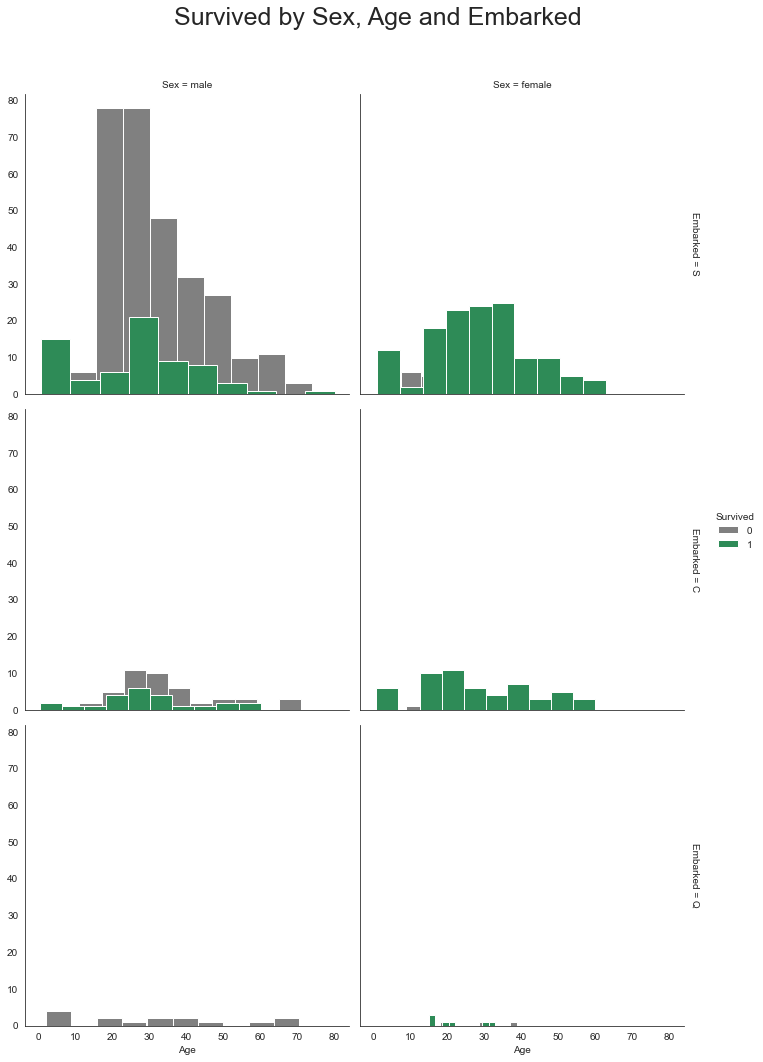

In [300]:
g = sns.FacetGrid(X_train,size=5, col="Sex", row="Embarked", margin_titles=True, hue = "Survived", palette = pal)
g = g.map(plt.hist, "Age", edgecolor = 'white').add_legend();
g.fig.suptitle("Survived by Sex, Age and Embarked", size = 25)
plt.subplots_adjust(top=0.90)

### Parch

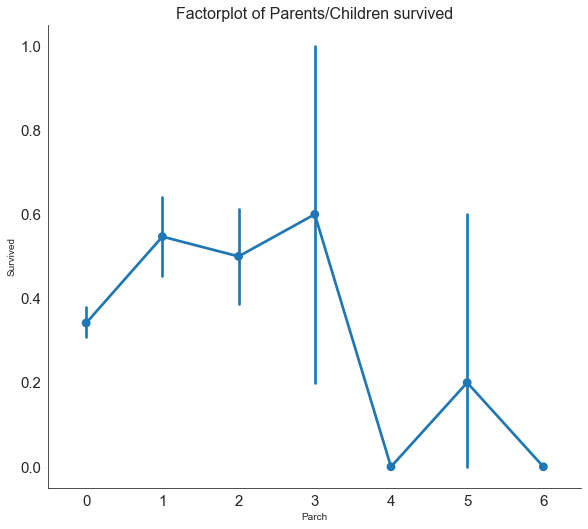

In [304]:
## factor plot
sns.factorplot(x = "Parch", y = "Survived", data = X_train,kind = "point",size = 8)
plt.title("Factorplot of Parents/Children survived", fontsize = 16)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.subplots_adjust(top=0.85)

### SibSp

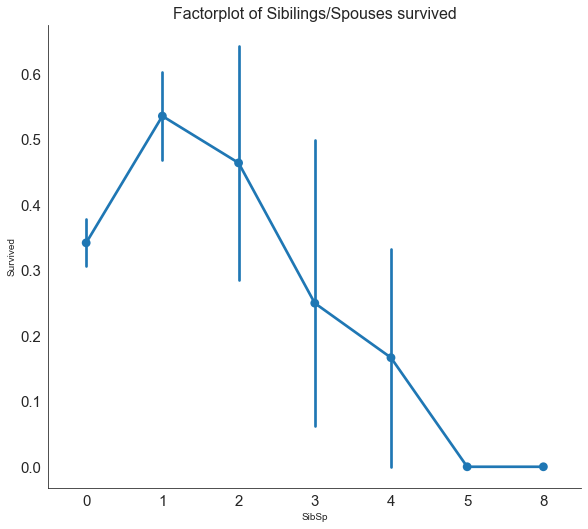

In [305]:
sns.factorplot(x =  "SibSp", y = "Survived", data = X_train, kind = "point",size = 8)
plt.title('Factorplot of Sibilings/Spouses survived', fontsize = 16)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.subplots_adjust(top=0.85)

## 2. Missing data

In [426]:
missing_vals = X.isnull().sum().sort_values(ascending = False)
percent = ( X.isnull().sum()/X.isnull().count() ).sort_values(ascending = False)
missing_df = pd.concat([missing_vals, percent], axis = 1, keys = ["Total", "Percent"])
total_missing = missing_df[missing_df['Total'] > 0]
total_missing

,Total,Percent
Cabin,1014,0.774637
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764


### Embarked: nominal catagorical variable

In [427]:
print(percent_value_counts(X, 'Embarked'))
X[X.Embarked.isnull()]

     Total  Percent
S      914    69.82
C      270    20.63
Q      123     9.40
NaN      2     0.15


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Here, I can either impute missing values with mode, which is S. Or:

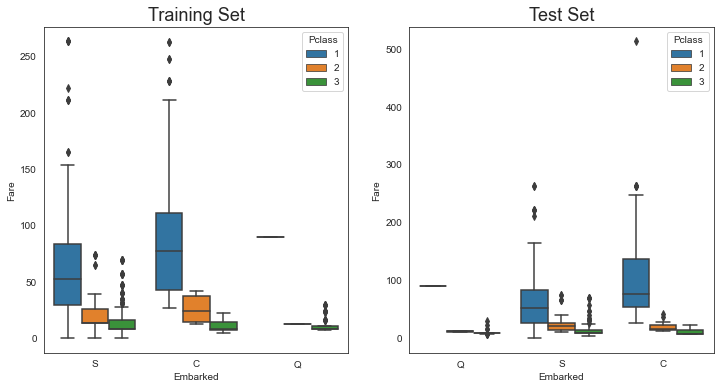

In [377]:
fig, ax = plt.subplots(figsize=(12,6),ncols=2)
ax1 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=X_train, ax = ax[0]);
ax2 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=df_test, ax = ax[1]);
ax1.set_title("Training Set", fontsize = 18)
ax2.set_title('Test Set',  fontsize = 18)
fig.show()

Looks like for people bought first class tickets, Embarked at C has a median closer to 80, which is what the two missing value paid for the fare.

In [428]:
## Replacing the null values in the Embarked column with C. 
X.Embarked.fillna("C", inplace=True)
X[X.Embarked.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Fare: continuous numerical variable

In [429]:
X[X.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Only one missing value for this variable. I can impute the missing value with mean or median of Fare. Or, I can use the information given (**Embarked** location, ticket **class**, and **gender**) and try something different:

In [430]:
impute_value = X[(X.Pclass == 3) & 
                (X.Embarked == "S") & 
                (X.Sex == "male")].Fare.median()

In [431]:
## replace the test.fare null values with test.fare median
X.Fare.fillna(impute_value, inplace=True)
X[X.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Cabin: nominal catagorical variable

In [382]:
print("Cabin missing in train set: " + str(X_train.Cabin.isnull().sum()/len(X_train.Cabin)))
print("Cabin missing in test set: " + str(df_test.Cabin.isnull().sum()/len(df_test.Cabin)))

Cabin missing in train set: 0.7725225225225225
Cabin missing in test set: 0.7822966507177034


Like before, I can drop this variable since so many values were missing in both the training and testing data sets. But:

In [432]:
## replace NaN with an arbituray cabin value N
X.Cabin.fillna("N", inplace=True)

In [433]:
## remove numbers in Cabin names, only leave the alphabetical part
X.Cabin = [i[0] for i in X.Cabin]
X.Cabin

0       N
1       C
2       N
3       C
4       N
       ..
1304    N
1305    C
1306    N
1307    N
1308    N
Name: Cabin, Length: 1309, dtype: object

In [434]:
percent_value_counts(X, "Cabin")

,Total,Percent
N,1014,77.46
C,94,7.18
B,65,4.97
D,46,3.51
E,41,3.13
A,22,1.68
F,21,1.60
G,5,0.38
T,1,0.08


In [435]:
## how much did people pay by Cabin?
X.groupby("Cabin")['Fare'].median().sort_values(ascending = False)

Cabin
C    86.2896
B    82.2667
E    53.1000
D    52.5542
T    35.5000
A    35.0771
G    16.7000
F    13.0000
N    10.5000
Name: Fare, dtype: float64

Can we assign each person in N to their corresponding Cabin based on the amount of $$ they paid?

In [436]:
with_N = X[X.Cabin == "N"]
without_N = X[X.Cabin != "N"]
with_N.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,N,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,N,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,N,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,N,C
12,13,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,N,S
13,14,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,N,S
14,15,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,N,S


In [437]:
##applying cabin estimator function. 
with_N['Cabin'] = with_N.Fare.apply(lambda x: cabin_estimator(x))
with_N.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,G,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,F,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,G,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,T,C
12,13,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,G,S
13,14,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,T,S
14,15,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,G,S


In [461]:
X_copy = pd.concat([with_N, without_N], axis=0)
X_copy = X_copy.drop(['Ticket', 'Name'], axis = 1)
X_copy.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,7.2500,G,S
2,3,3,female,26.0,0,0,7.9250,G,S
4,5,3,male,35.0,0,0,8.0500,G,S
5,6,3,male,NaN,0,0,8.4583,G,Q
7,8,3,male,2.0,3,1,21.0750,F,S
8,9,3,female,27.0,0,2,11.1333,G,S
9,10,2,female,14.0,1,0,30.0708,T,C
12,13,3,male,20.0,0,0,8.0500,G,S
13,14,3,male,39.0,1,5,31.2750,T,S
14,15,3,female,14.0,0,0,7.8542,G,S


In [462]:
X_copy.sort_values(by = 'PassengerId', inplace=True)
X_copy.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,7.2500,G,S
1,2,1,female,38.0,1,0,71.2833,C,C
2,3,3,female,26.0,0,0,7.9250,G,S
3,4,1,female,35.0,1,0,53.1000,C,S
4,5,3,male,35.0,0,0,8.0500,G,S
5,6,3,male,NaN,0,0,8.4583,G,Q
6,7,1,male,54.0,0,0,51.8625,E,S
7,8,3,male,2.0,3,1,21.0750,F,S
8,9,3,female,27.0,0,2,11.1333,G,S
9,10,2,female,14.0,1,0,30.0708,T,C


In [440]:
X_copy

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,7.2500,G,S
1,2,1,female,38.0,1,0,71.2833,C,C
2,3,3,female,26.0,0,0,7.9250,G,S
3,4,1,female,35.0,1,0,53.1000,C,S
4,5,3,male,35.0,0,0,8.0500,G,S
...,...,...,...,...,...,...,...,...,...
1304,1305,3,male,NaN,0,0,8.0500,G,S
1305,1306,1,female,39.0,0,0,108.9000,C,C
1306,1307,3,male,38.5,0,0,7.2500,G,S
1307,1308,3,male,NaN,0,0,8.0500,G,S


In [441]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,N,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,N,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,1


### Age: continuous numerical variable

In [442]:
print ("Age missing value in training set: " + str((X_train.Age.isnull().sum()/len(X_train))*100)+str("%"))
print ("Age missing value in testing set: " + str((df_test.Age.isnull().sum()/len(df_test))*100)+str("%"))

Age missing value in training set: 19.865319865319865%
Age missing value in testing set: 20.574162679425836%


I like the idea that instead of imputing missing values with mean or median age, we predict those missing values by training a random forest model on sex, sibsp, parch, etc. I'll come back to this later. Now I'll impute with median value.

There'll be a lot of 28 year-old... probably not a good idea... we'll see.

In [463]:
X_copy.Age = X_copy.Age.fillna(X_train.Age.median())

In [464]:
X_copy['Sex'].replace(['male','female'],[0,1],inplace=True)

In [465]:
X_copy['family_size'] = X_copy.SibSp + X_copy.Parch+1

In [466]:
X_copy['is_alone'] = [1 if i<2 else 0 for i in X_copy.family_size]

In [467]:
## Applying "age_group_fun" function to the "Age" column.
X_copy['age_group'] = X_copy['Age'].map(age_group_fun)

In [468]:
## Creating dummies for "age_group" feature. 
X_copy = pd.get_dummies(X_copy,columns=['age_group', 'Embarked', 'Cabin', 'Pclass'], drop_first=True)

In [469]:
X_copy['norm_fare'] = np.log(X_copy.Fare+1)
#X_copy = X_copy.drop(['Fare', 'PassengerId'], axis = 1)

In [470]:
X_copy.head(10)

,PassengerId,Sex,Age,SibSp,Parch,Fare,family_size,is_alone,age_group_child,age_group_elderly,age_group_infant,age_group_middleAged,age_group_senior,age_group_teenager,age_group_toddler,age_group_youngAdult,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_2,Pclass_3,norm_fare
0,1,0,22.0,1,0,7.2500,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.110213
1,2,1,38.0,1,0,71.2833,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4.280593
2,3,1,26.0,0,0,7.9250,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.188856
3,4,1,35.0,1,0,53.1000,2,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,3.990834
4,5,0,35.0,0,0,8.0500,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.202765
5,6,0,28.0,0,0,8.4583,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,2.246893
6,7,0,54.0,0,0,51.8625,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3.967694
7,8,0,2.0,3,1,21.0750,5,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,3.094446
8,9,1,27.0,0,2,11.1333,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.495954
9,10,1,14.0,1,0,30.0708,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,3.436268


In [471]:
X_train = X_copy.iloc[:trainrow]

In [472]:
X_train.tail(10)

,PassengerId,Sex,Age,SibSp,Parch,Fare,family_size,is_alone,age_group_child,age_group_elderly,age_group_infant,age_group_middleAged,age_group_senior,age_group_teenager,age_group_toddler,age_group_youngAdult,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_2,Pclass_3,norm_fare
881,882,0,33.0,0,0,7.8958,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.185579
882,883,1,22.0,0,0,10.5167,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.443798
883,884,0,28.0,0,0,10.5000,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,2.442347
884,885,0,25.0,0,0,7.0500,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.085672
885,886,1,39.0,0,5,29.1250,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,3.405355
886,887,0,27.0,0,0,13.0000,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,2.639057
887,888,1,19.0,0,0,30.0000,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,3.433987
888,889,1,28.0,1,2,23.4500,4,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,3.196630
889,890,0,26.0,0,0,30.0000,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3.433987
890,891,0,32.0,0,0,7.7500,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,2.169054


In [473]:
df_test = X_copy.iloc[trainrow:]

In [474]:
df_test.head(10)

,PassengerId,Sex,Age,SibSp,Parch,Fare,family_size,is_alone,age_group_child,age_group_elderly,age_group_infant,age_group_middleAged,age_group_senior,age_group_teenager,age_group_toddler,age_group_youngAdult,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_2,Pclass_3,norm_fare
891,892,0,34.5,0,0,7.8292,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,2.178064
892,893,1,47.0,1,0,7.0000,2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,2.079442
893,894,0,62.0,0,0,9.6875,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,2.369075
894,895,0,27.0,0,0,8.6625,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.268252
895,896,1,22.0,1,1,12.2875,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,2.586824
896,897,0,14.0,0,0,9.2250,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,2.324836
897,898,1,30.0,0,0,7.6292,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,2.155152
898,899,0,26.0,1,1,29.0000,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3.401197
899,900,1,18.0,0,0,7.2292,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,2.107689
900,901,0,21.0,2,0,24.1500,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,3.224858


In [475]:
X_train.shape

(891, 28)

In [476]:
df_test.shape

(418, 28)

In [477]:
df_test.to_csv('./data/test_ready.csv', index=False)

In [478]:
# adding saved target variable with train. 
X_train['Survived'] = y_train

In [479]:
X_train = X_train[X_train.Fare < 500]

In [480]:
X_train.shape

(888, 29)

In [481]:
X_train.to_csv('./data/train_ready.csv', index=False)